# Wood Finish Classification using LAB Color Space

This notebook builds a classification model for wood finishes (medium cherry, desert oak, and graphite walnut) by preprocessing images to LAB color space for improved accuracy.

## 1. Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
from pathlib import Path

# For image processing
import cv2
from PIL import Image

# For model building
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# For evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Check if GPU is available
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.16.2
GPU Available:  True


In [2]:
# Add after imports section
import os
import numpy as np
import pathlib
from tqdm.notebook import tqdm
import cv2

# Set up paths similar to your working example
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 3  # Three wood types
BASE_DATA_DIR = pathlib.Path("/Users/rishimanimaran/Documents/College/junior-year/spring-2025/cs-3312/color-validation-app-spring/imagesDataset")

# Wood type classes
CLASS_NAMES = ["desert_oak", "graphite_walnut", "medium_cherry"]

# Lighting conditions - we'll use these to navigate the directory structure
LIGHTING_CONDITIONS = [
    "in-range-dark",
    "in-range-light",
    "in-range-normal",
    "out-of-range-too-dark",
    "out-of-range-too-light"
]

# Function to load images and convert to LAB
def load_and_convert_to_lab(base_data_dir, class_names, lighting_conditions, img_size):
    """
    Load images from all wood type directories and their lighting condition subdirectories,
    and convert them to LAB color space.

    Args:
        base_data_dir: Base directory containing wood type folders
        class_names: List of wood type folder names
        lighting_conditions: List of lighting condition subfolder names
        img_size: Target size for images (img_size x img_size)

    Returns:
        images: Numpy array of LAB images
        labels: Numpy array of integer labels (wood type)
    """
    images = []
    labels = []

    for i, wood_type in enumerate(class_names):
        wood_dir = base_data_dir / wood_type
        print(f"Processing wood type {i}: {wood_type}")

        # Check if wood type directory exists
        if not wood_dir.exists():
            print(f"Warning: Wood type directory {wood_dir} not found. Skipping.")
            continue

        # Process each lighting condition
        for light_cond in lighting_conditions:
            light_dir = wood_dir / light_cond
            print(f"  Processing lighting condition: {light_cond}")

            # Check if lighting condition directory exists
            if not light_dir.exists():
                print(f"  Warning: Lighting condition directory {light_dir} not found. Skipping.")
                continue

            # Get all image files using os.listdir as in your working example
            image_files = [f for f in os.listdir(light_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            print(f"  Found {len(image_files)} images in {wood_type}/{light_cond}")

            for img_file in tqdm(image_files, desc=f"{wood_type}/{light_cond}", disable=True):
                img_path = light_dir / img_file
                try:
                    # Read image
                    img = cv2.imread(str(img_path))
                    if img is None:
                        print(f"    Warning: Could not read {img_path}. Skipping.")
                        continue

                    # Convert BGR to RGB (OpenCV loads as BGR)
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Resize to target dimensions
                    img_resized = cv2.resize(img_rgb, (img_size, img_size))

                    # Convert RGB to LAB
                    img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)

                    # Normalize LAB values to 0-1 range for the model
                    l_channel = img_lab[:,:,0] / 100.0  # Normalize L to [0, 1]
                    a_channel = (img_lab[:,:,1] + 127) / 255.0  # Normalize a to [0, 1]
                    b_channel = (img_lab[:,:,2] + 127) / 255.0  # Normalize b to [0, 1]

                    # Stack normalized channels
                    normalized_lab = np.stack([l_channel, a_channel, b_channel], axis=-1)

                    images.append(normalized_lab)
                    labels.append(i)  # Wood type label

                except Exception as e:
                    print(f"    Error processing {img_path}: {e}")

    if len(images) == 0:
        raise ValueError("No images were loaded. Please check the directory structure and image formats.")

    return np.array(images), np.array(labels)

# Verify the wood type folders exist
print("Checking folder structure:")
for wood_type in CLASS_NAMES:
    wood_path = BASE_DATA_DIR / wood_type
    if not wood_path.exists():
        print(f"Warning: Wood type directory {wood_path} does not exist")
    else:
        print(f"Found wood type: {wood_type}")

        # Check if all lighting condition folders exist
        for light_cond in LIGHTING_CONDITIONS:
            light_path = wood_path / light_cond
            if not light_path.exists():
                print(f"  Warning: Lighting condition directory {light_path} does not exist")
            else:
                try:
                    image_files = [f for f in os.listdir(light_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                    print(f"  - {light_cond}: {len(image_files)} images")
                except Exception as e:
                    print(f"  - {light_cond}: Error listing files: {e}")

# Load all images with LAB conversion
print("\nLoading images and converting to LAB color space...")
all_images, all_labels = load_and_convert_to_lab(BASE_DATA_DIR, CLASS_NAMES, LIGHTING_CONDITIONS, IMG_SIZE)
print(f"Loaded {len(all_images)} total images with shape {all_images.shape}")

Checking folder structure:
Found wood type: desert_oak
  - in-range-dark: 38 images
  - in-range-light: 49 images
  - in-range-normal: 36 images
  - out-of-range-too-dark: 24 images
Found wood type: graphite_walnut
  - in-range-dark: 49 images
  - in-range-light: 37 images
  - in-range-normal: 33 images
  - out-of-range-too-dark: 39 images
  - out-of-range-too-light: 47 images
Found wood type: medium_cherry
  - in-range-dark: 77 images
  - in-range-light: 92 images
  - out-of-range-too-dark: 13 images
  - out-of-range-too-light: 10 images

Loading images and converting to LAB color space...
Processing wood type 0: desert_oak
  Processing lighting condition: in-range-dark
  Found 38 images in desert_oak/in-range-dark
  Processing lighting condition: in-range-light
  Found 49 images in desert_oak/in-range-light
  Processing lighting condition: in-range-normal
  Found 36 images in desert_oak/in-range-normal
  Processing lighting condition: out-of-range-too-dark
  Found 24 images in desert

## 2. Data Loading and LAB Preprocessing

### 2.1 Configure Data Paths

### 2.2 Load and Convert Images to LAB Color Space

In [3]:
'''
def load_and_convert_to_lab(base_dir, class_names, img_size):
    """
    Load images from directories and convert to LAB color space

    Args:
        base_dir: Base directory containing class folders
        class_names: List of class folder names
        img_size: Target size for images (img_size x img_size)

    Returns:
        images: Numpy array of LAB images
        labels: Numpy array of integer labels
    """
    images = []
    labels = []
    base_dir = Path(base_dir)

    for i, class_name in enumerate(class_names):
        class_dir = base_dir / class_name
        print(f"Processing class {i}: {class_name}")

        # Check if directory exists
        if not class_dir.exists():
            print(f"Warning: Directory {class_dir} not found. Skipping.")
            continue

        # Get all image files
        image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg')) + \
                      list(class_dir.glob('*.png')) + list(class_dir.glob('*.bmp'))

        print(f"Found {len(image_files)} images in {class_name}")

        for img_path in tqdm(image_files, desc=class_name):
            try:
                # Read image using OpenCV
                img = cv2.imread(str(img_path))
                if img is None:
                    print(f"Warning: Could not read {img_path}. Skipping.")
                    continue

                # Convert BGR to RGB (OpenCV loads as BGR)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize to target dimensions
                img_resized = cv2.resize(img_rgb, (img_size, img_size))

                # Convert RGB to LAB
                img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)

                # Normalize LAB values to 0-1 range for the model
                # L channel is in range [0, 100], a and b channels are in range [-127, 127]
                l_channel = img_lab[:,:,0] / 100.0  # Normalize L to [0, 1]
                a_channel = (img_lab[:,:,1] + 127) / 255.0  # Normalize a to [0, 1]
                b_channel = (img_lab[:,:,2] + 127) / 255.0  # Normalize b to [0, 1]

                # Stack normalized channels
                normalized_lab = np.stack([l_channel, a_channel, b_channel], axis=-1)

                images.append(normalized_lab)
                labels.append(i)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    if len(images) == 0:
        raise ValueError("No images were loaded. Please check the directory structure and image formats.")

    return np.array(images), np.array(labels)

# Load all images and convert to LAB
print("Loading images and converting to LAB color space...")
all_images, all_labels = load_and_convert_to_lab(BASE_DATA_DIR, CLASS_NAMES, IMG_SIZE)
print(f"Loaded {len(all_images)} total images with shape {all_images.shape}") '''

'\ndef load_and_convert_to_lab(base_dir, class_names, img_size):\n    """\n    Load images from directories and convert to LAB color space\n\n    Args:\n        base_dir: Base directory containing class folders\n        class_names: List of class folder names\n        img_size: Target size for images (img_size x img_size)\n\n    Returns:\n        images: Numpy array of LAB images\n        labels: Numpy array of integer labels\n    """\n    images = []\n    labels = []\n    base_dir = Path(base_dir)\n\n    for i, class_name in enumerate(class_names):\n        class_dir = base_dir / class_name\n        print(f"Processing class {i}: {class_name}")\n\n        # Check if directory exists\n        if not class_dir.exists():\n            print(f"Warning: Directory {class_dir} not found. Skipping.")\n            continue\n\n        # Get all image files\n        image_files = list(class_dir.glob(\'*.jpg\')) + list(class_dir.glob(\'*.jpeg\')) +                       list(class_dir.glob(\'*.png\

### 2.3 Visualize LAB Color Space

Let's visualize the LAB color space to understand what our model will be working with:

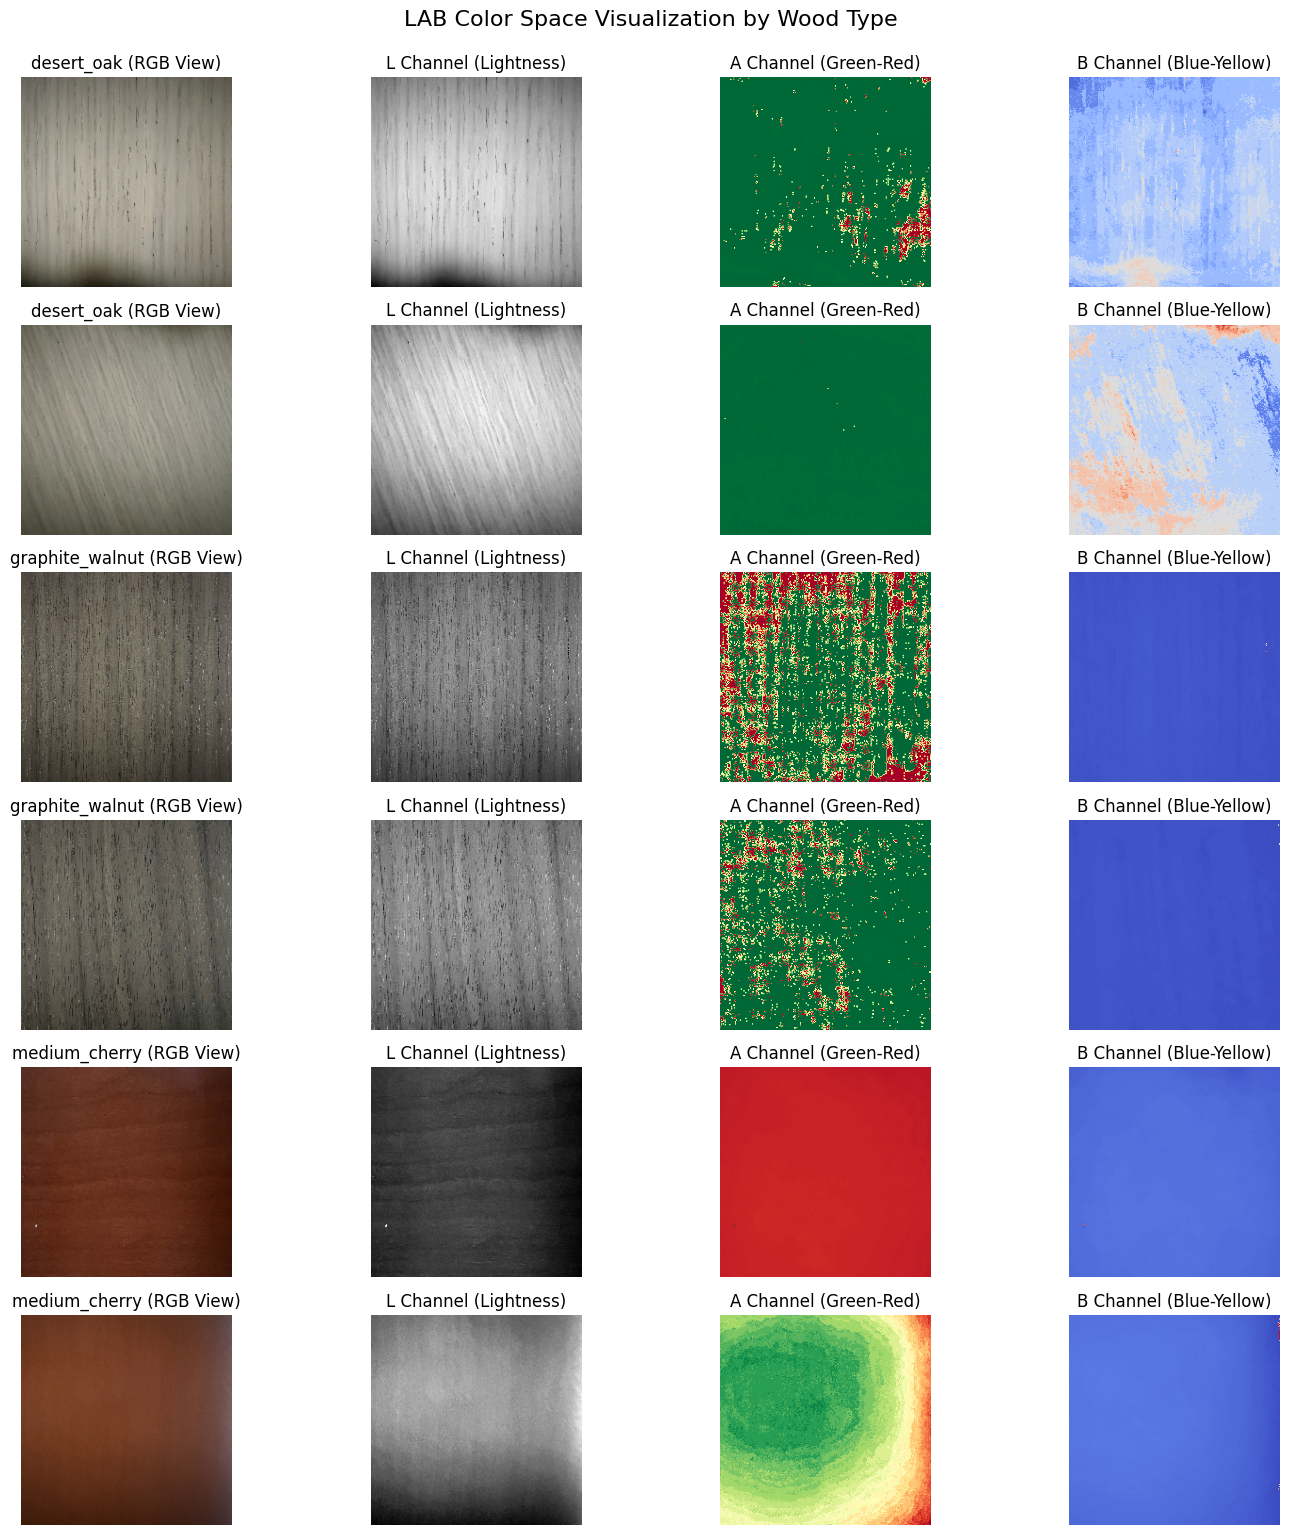

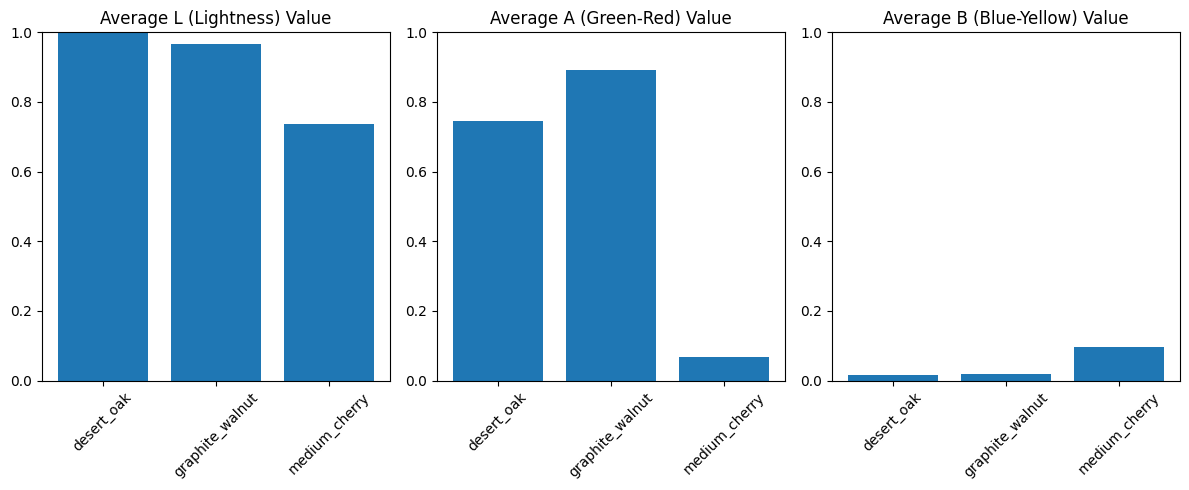

In [4]:
def visualize_lab_channels(images, labels, class_names, num_samples=2):
    """
    Visualize LAB channels for sample images from each class
    """
    plt.figure(figsize=(15, 5 * len(class_names)))

    for i, class_name in enumerate(class_names):
        # Find indices of images from this class
        indices = np.where(labels == i)[0]

        # Randomly sample some images
        if len(indices) > 0:
            sample_indices = np.random.choice(indices,
                                             size=min(num_samples, len(indices)),
                                             replace=False)

            for j, idx in enumerate(sample_indices):
                lab_img = images[idx]

                # Extract LAB channels
                l_channel = lab_img[:,:,0]  # Already normalized to [0, 1]
                a_channel = lab_img[:,:,1]  # Already normalized to [0, 1]
                b_channel = lab_img[:,:,2]  # Already normalized to [0, 1]

                # Convert back to RGB for display
                # First denormalize
                l_denorm = l_channel * 100
                a_denorm = a_channel * 255 - 127
                b_denorm = b_channel * 255 - 127
                # Reconstruct LAB image (OpenCV format)
                lab_denorm = np.stack([l_denorm, a_denorm, b_denorm], axis=-1).astype(np.uint8)
                # Convert back to RGB
                rgb_img = cv2.cvtColor(lab_denorm, cv2.COLOR_LAB2RGB)

                # Plot images
                row_base = i * num_samples + j

                # Original (converted back to RGB)
                plt.subplot(len(class_names) * num_samples, 4, row_base * 4 + 1)
                plt.imshow(rgb_img)
                plt.title(f"{class_name} (RGB View)")
                plt.axis('off')

                # L channel
                plt.subplot(len(class_names) * num_samples, 4, row_base * 4 + 2)
                plt.imshow(l_channel, cmap='gray')
                plt.title("L Channel (Lightness)")
                plt.axis('off')

                # A channel
                plt.subplot(len(class_names) * num_samples, 4, row_base * 4 + 3)
                plt.imshow(a_channel, cmap='RdYlGn')
                plt.title("A Channel (Green-Red)")
                plt.axis('off')

                # B channel
                plt.subplot(len(class_names) * num_samples, 4, row_base * 4 + 4)
                plt.imshow(b_channel, cmap='coolwarm')
                plt.title("B Channel (Blue-Yellow)")
                plt.axis('off')

    plt.tight_layout()
    plt.suptitle("LAB Color Space Visualization by Wood Type", y=1.02, fontsize=16)
    plt.show()

# Visualize LAB channels
visualize_lab_channels(all_images, all_labels, CLASS_NAMES)

# Calculate and visualize average LAB values per class
plt.figure(figsize=(12, 5))

# Calculate average channel values per class
avg_values = []
for i, class_name in enumerate(CLASS_NAMES):
    class_indices = np.where(all_labels == i)[0]
    class_images = all_images[class_indices]

    # Calculate average per channel
    avg_l = np.mean(class_images[:,:,:,0])
    avg_a = np.mean(class_images[:,:,:,1])
    avg_b = np.mean(class_images[:,:,:,2])

    avg_values.append([avg_l, avg_a, avg_b])

# Convert to numpy array for easier plotting
avg_values = np.array(avg_values)

# Plot average values for each channel
channels = ['L (Lightness)', 'A (Green-Red)', 'B (Blue-Yellow)']
for c in range(3):
    plt.subplot(1, 3, c+1)
    plt.bar(CLASS_NAMES, avg_values[:,c])
    plt.title(f"Average {channels[c]} Value")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 2.4 Split Data into Training, Validation, and Test Sets

Training set: 380 images
Validation set: 82 images
Testing set: 82 images


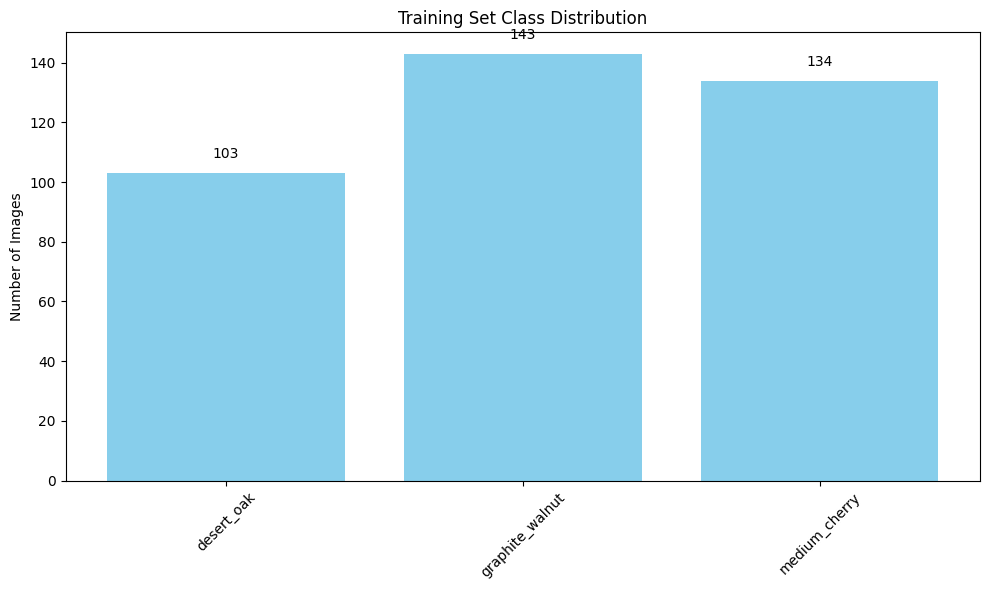


Training Set Class Distribution:
  desert_oak: 103 images (27.1%)
  graphite_walnut: 143 images (37.6%)
  medium_cherry: 134 images (35.3%)


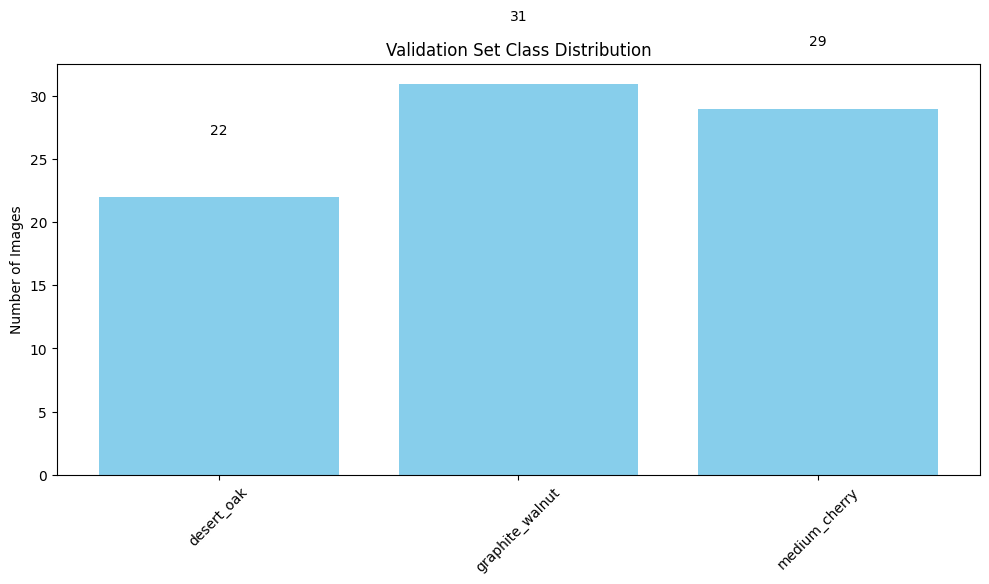


Validation Set Class Distribution:
  desert_oak: 22 images (26.8%)
  graphite_walnut: 31 images (37.8%)
  medium_cherry: 29 images (35.4%)


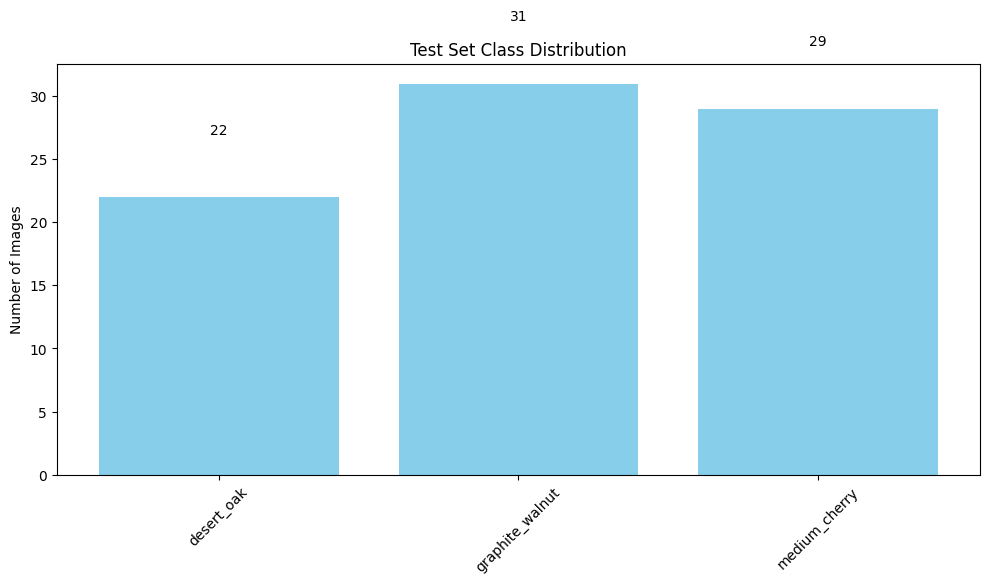


Test Set Class Distribution:
  desert_oak: 22 images (26.8%)
  graphite_walnut: 31 images (37.8%)
  medium_cherry: 29 images (35.4%)


In [5]:
# Split into train, validation, and test sets (70%/15%/15% split)
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=RANDOM_SEED, stratify=all_labels
)

val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=RANDOM_SEED, stratify=test_labels
)

print(f"Training set: {train_images.shape[0]} images")
print(f"Validation set: {val_images.shape[0]} images")
print(f"Testing set: {test_images.shape[0]} images")

# Convert labels to categorical (one-hot encoding)
train_labels_cat = to_categorical(train_labels, NUM_CLASSES)
val_labels_cat = to_categorical(val_labels, NUM_CLASSES)
test_labels_cat = to_categorical(test_labels, NUM_CLASSES)

# Function to display class distribution
def show_class_distribution(labels, title="Class Distribution"):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip([CLASS_NAMES[int(i)] for i in unique], counts))

    plt.figure(figsize=(10, 6))
    plt.bar(distribution.keys(), distribution.values(), color='skyblue')
    plt.title(title)
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)

    # Add counts on top of bars
    for i, count in enumerate(distribution.values()):
        plt.text(i, count + 5, str(count), ha='center')

    plt.tight_layout()
    plt.show()

    # Print percentages
    print(f"\n{title}:")
    total = sum(distribution.values())
    for class_name, count in distribution.items():
        print(f"  {class_name}: {count} images ({count/total*100:.1f}%)")

# Display class distributions
show_class_distribution(train_labels, "Training Set Class Distribution")
show_class_distribution(val_labels, "Validation Set Class Distribution")
show_class_distribution(test_labels, "Test Set Class Distribution")

### 2.5 Data Augmentation

In [6]:
# Set up data augmentation for training
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],  # Be careful with brightness in LAB space
    zoom_range=0.1,
    fill_mode='nearest'
)
'''
# Visualize augmented LAB images
def show_augmented_lab_images(original_image):
    plt.figure(figsize=(12, 6))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if i == 0:
            sample_image = original_image[0:1]  # Select first image and keep dimensions
            plt.title('Original')
        else:
            # Create augmented image
            batch = data_augmentation.flow(original_image[0:1], batch_size=1)
            augmented_images = batch.next()
            sample_image = augmented_images[0]
            plt.title(f'Augmented #{i}')

        # Convert LAB back to RGB for display
        img = sample_image.copy()
        # Denormalize
        l = img[:,:,0] * 100
        a = img[:,:,1] * 255 - 127
        b = img[:,:,2] * 255 - 127
        # Reconstruct LAB image (OpenCV format)
        lab_img_cv = np.stack([l, a, b], axis=-1).astype(np.uint8)
        # Convert back to RGB for display
        rgb_img = cv2.cvtColor(lab_img_cv, cv2.COLOR_LAB2RGB)
        plt.imshow(rgb_img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select a sample image (first image from training set)
sample_img = train_images[0:1]

# Visualize augmentation
print("LAB Image Augmentation Examples:")
show_augmented_lab_images(sample_img)
'''

'\n# Visualize augmented LAB images\ndef show_augmented_lab_images(original_image):\n    plt.figure(figsize=(12, 6))\n\n    for i in range(9):\n        ax = plt.subplot(3, 3, i + 1)\n        if i == 0:\n            sample_image = original_image[0:1]  # Select first image and keep dimensions\n            plt.title(\'Original\')\n        else:\n            # Create augmented image\n            batch = data_augmentation.flow(original_image[0:1], batch_size=1)\n            augmented_images = batch.next()\n            sample_image = augmented_images[0]\n            plt.title(f\'Augmented #{i}\')\n\n        # Convert LAB back to RGB for display\n        img = sample_image.copy()\n        # Denormalize\n        l = img[:,:,0] * 100\n        a = img[:,:,1] * 255 - 127\n        b = img[:,:,2] * 255 - 127\n        # Reconstruct LAB image (OpenCV format)\n        lab_img_cv = np.stack([l, a, b], axis=-1).astype(np.uint8)\n        # Convert back to RGB for display\n        rgb_img = cv2.cvtColor(l

## 3. Model Development and Training

### 3.1 Building the Model

In [ ]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """
    Build a wood classification model using transfer learning with MobileNetV2
    """
    # Base model - MobileNetV2
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_model()
model.summary()

2025-03-06 23:02:18.849185: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-06 23:02:18.849220: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-06 23:02:18.849237: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-06 23:02:18.849257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-06 23:02:18.849273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435,523 (9.29 MB)

 Trainable params: 174,979 (683.51 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

: 

### 3.2 Training the Model

In [ ]:
# Define callbacks
def get_callbacks():
    return [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ),
        callbacks.ModelCheckpoint(
            'wood_classifier_lab_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]

# Train the model
print("Training the model...")
history = model.fit(
    data_augmentation.flow(train_images, train_labels_cat, batch_size=BATCH_SIZE),
    validation_data=(val_images, val_labels_cat),
    epochs=30,
    callbacks=get_callbacks(),
    verbose=1
)

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Training the model...


/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


### 3.3 Fine-tuning the Model

Fine-tuning the model...
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5011 - loss: 1.0822

27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5008 - loss: 1.0818 - val_accuracy: 0.6923 - val_loss: 0.7971 - learning_rate: 1.0000e-05
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4942 - loss: 1.1033

27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4947 - loss: 1.1014 - val_accuracy: 0.7253 - val_loss: 0.7784 - learning_rate: 1.0000e-05
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5575 - loss: 1.0294 - val_accuracy: 0.7253 - val_loss: 0.7696 - learning_rate: 1.0000e-05
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6006 - loss: 0.8860 - val_accuracy: 0.7253 - val_loss: 0.7671 - learning_rate: 1.0000e-05
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6132 - loss: 0.8188 - val_accuracy: 0.7253 - val_loss: 0.7739 - learning_rate: 1.0000e-05
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6281 - loss: 0.8060 - val_accuracy: 0.7253 - val_loss: 0.7840 - learning_rate: 1.0000e-05
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5887 - loss: 0.8609 - val_accuracy: 0.7143 - val_loss: 0.7893 - learning_rate: 1.0000e-05
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6112 - loss: 0.8677

27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6107 - loss: 0.8685 - val_accuracy: 0.7363 - val_loss: 0.7950 - learning_rate: 1.0000e-05
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6025 - loss: 0.8463

27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6022 - loss: 0.8458 - val_accuracy: 0.7473 - val_loss: 0.8047 - learning_rate: 1.0000e-05
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6122 - loss: 0.8166 - val_accuracy: 0.7473 - val_loss: 0.8199 - learning_rate: 5.0000e-06
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5702 - loss: 0.9075 - val_accuracy: 0.7473 - val_loss: 0.8275 - learning_rate: 5.0000e-06
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5871 - loss: 0.8066 - val_accuracy: 0.7143 - val_loss: 0.8384 - learning_rate: 5.0000e-06
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6399 - loss: 0.7859 - val_accuracy: 0.7253 - val_loss: 0.8523 - learning_rate: 5.0000e-06
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6307 - loss: 0.7729 - val_accuracy: 0.7033 - val_loss: 0.8641 - learning_rate: 5.0000e-06


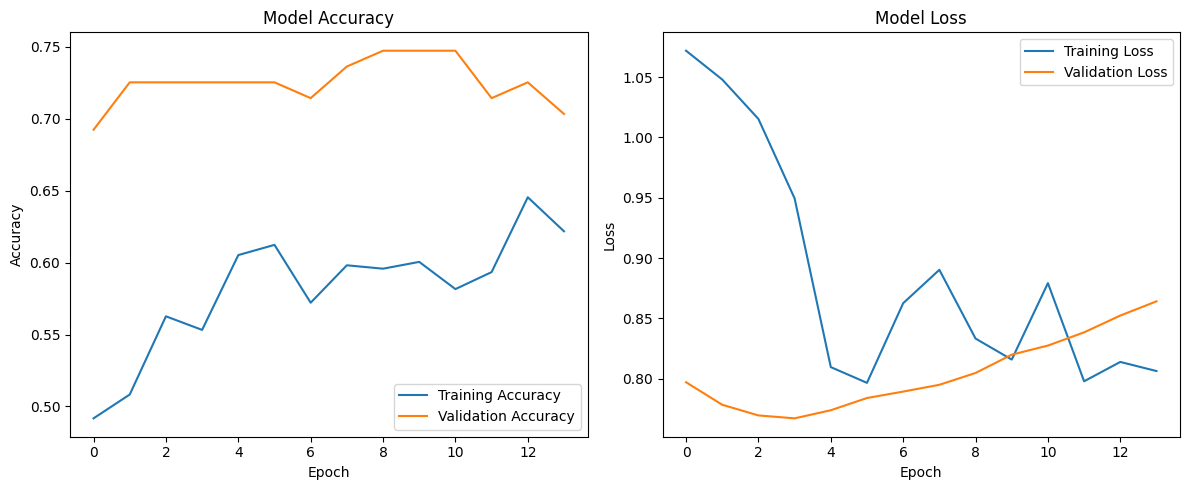

In [ ]:
# Fine-tune the model
print("Fine-tuning the model...")

# Unfreeze the top layers of the base model
base_model = model.layers[0]
base_model.trainable = True

# Freeze the bottom layers and unfreeze the top layers
for layer in base_model.layers[:-30]:  # Keep the bottom layers frozen
    layer.trainable = False
for layer in base_model.layers[-30:]:  # Unfreeze the top layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_history = model.fit(
    data_augmentation.flow(train_images, train_labels_cat, batch_size=BATCH_SIZE // 2),
    validation_data=(val_images, val_labels_cat),
    epochs=20,
    callbacks=get_callbacks(),
    verbose=1
)

# Plot fine-tuning history
plot_training_history(fine_tune_history)

## 4. Model Evaluation

Let's evaluate our model on the test set:

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6828 - loss: 0.7626
Test accuracy: 0.6703
Test loss: 0.8038
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step

Classification Report:
                 precision    recall  f1-score   support

     desert_oak       0.46      0.27      0.34        22
graphite_walnut       0.63      0.61      0.62        31
  medium_cherry       0.75      0.95      0.84        38

       accuracy                           0.67        91
      macro avg       0.61      0.61      0.60        91
   weighted avg       0.64      0.67      0.64        91



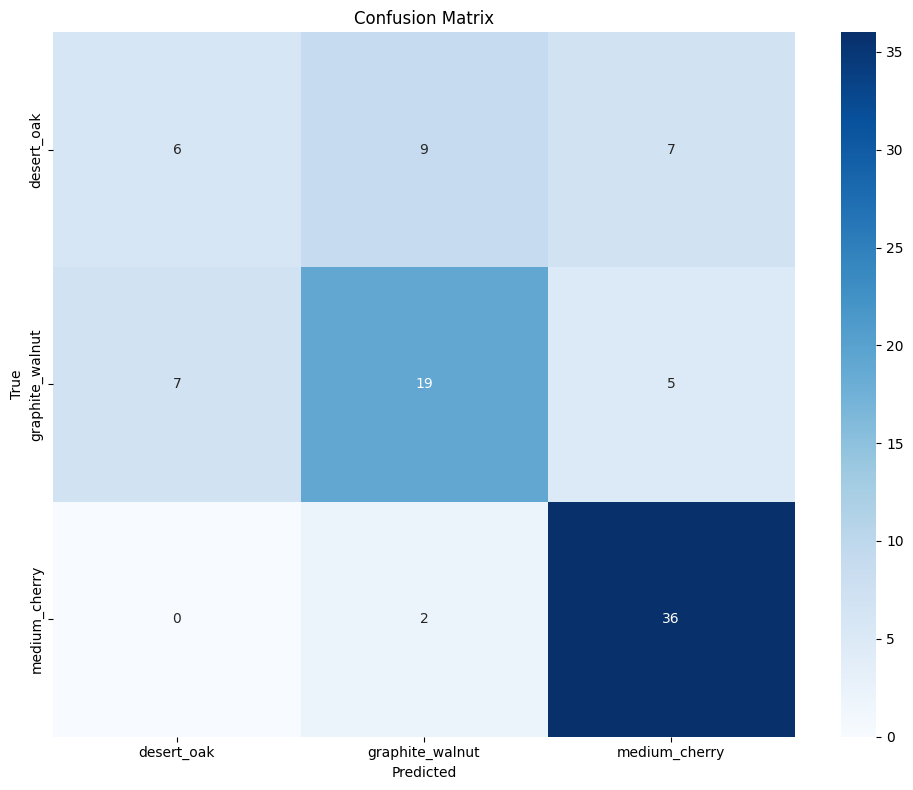

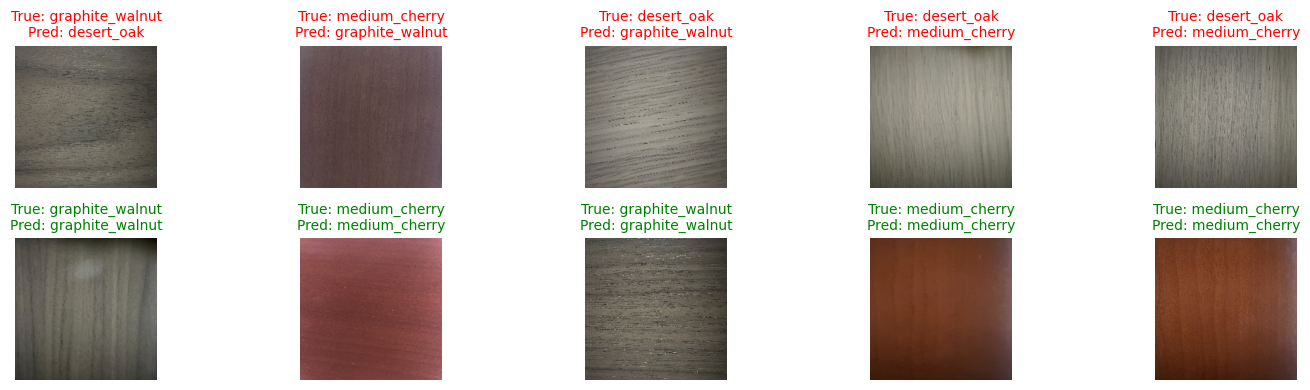

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_cat)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred_prob = model.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print classification report
print("\nClassification Report:")
report = classification_report(test_labels, y_pred, target_names=CLASS_NAMES)
print(report)

# Create confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Visualize predictions
def visualize_predictions(images, true_labels, pred_labels, class_names, num_samples=10):
    # Find both correct and incorrect predictions
    correct_indices = np.where(true_labels == pred_labels)[0]
    incorrect_indices = np.where(true_labels != pred_labels)[0]

    # Determine how many of each to show
    n_incorrect = min(num_samples // 2, len(incorrect_indices))
    n_correct = min(num_samples - n_incorrect, len(correct_indices))

    # Select random samples
    if len(incorrect_indices) > 0:
        selected_incorrect = np.random.choice(incorrect_indices, n_incorrect, replace=False)
    else:
        selected_incorrect = []

    selected_correct = np.random.choice(correct_indices, n_correct, replace=False)

    # Combine indices
    selected_indices = np.concatenate([selected_incorrect, selected_correct])

    # Create figure
    plt.figure(figsize=(15, 2 * ((len(selected_indices) + 4) // 5)))

    for i, idx in enumerate(selected_indices):
        img = images[idx]

        # Convert LAB back to RGB for display
        l = img[:,:,0] * 100
        a = img[:,:,1] * 255 - 127
        b = img[:,:,2] * 255 - 127
        lab_img_cv = np.stack([l, a, b], axis=-1).astype(np.uint8)
        rgb_img = cv2.cvtColor(lab_img_cv, cv2.COLOR_LAB2RGB)

        plt.subplot(((len(selected_indices) + 4) // 5), 5, i + 1)
        plt.imshow(rgb_img)

        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]

        if true_labels[idx] == pred_labels[idx]:
            color = 'green'
        else:
            color = 'red'

        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(test_images, test_labels, y_pred, CLASS_NAMES)

## 5. Save and Convert Model for Deployment

In [ ]:
# Save the Keras model
model.save('wood_classifier_lab.h5')
print("Saved Keras model to wood_classifier_lab.h5")

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('wood_classifier_lab.tflite', 'wb') as f:
    f.write(tflite_model)
print("Saved TFLite model to wood_classifier_lab.tflite")

# Convert to optimized TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_optimized_model = converter.convert()

# Save the optimized TFLite model
with open('wood_classifier_lab_optimized.tflite', 'wb') as f:
    f.write(tflite_optimized_model)
print("Saved optimized TFLite model to wood_classifier_lab_optimized.tflite")

Saved Keras model to wood_classifier_lab.h5
Saved artifact at '/tmp/tmp1220uv9b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132313745505936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745505360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745506128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745505168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745505552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745504208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313748669840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313748668496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313748669456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313748668880: TensorSpec(shape=()

## 6. Test the TFLite Model

Input details: [{'name': 'serving_default_keras_tensor_154:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 178, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


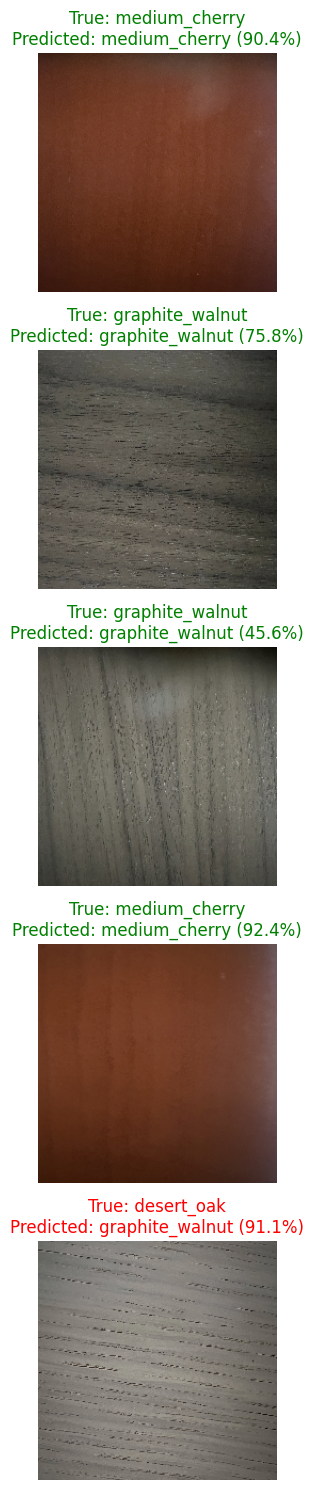

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# Test the TFLite model on a few images
def test_tflite_model(interpreter, images, labels, class_names, num_samples=5):
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Create a figure for visualization
    plt.figure(figsize=(15, 3 * num_samples))

    # Test on random samples
    indices = np.random.choice(range(len(images)), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Process input

        input_image = images[idx:idx+1].astype(np.float32)  # This is the fix
        interpreter.set_tensor(input_details[0]['index'], input_image)

        # Run inference
        interpreter.invoke()

        # Get the output
        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = np.argmax(output[0])

        # Calculate confidence
        confidence = output[0][predicted_class] * 100

        # Display results
        plt.subplot(num_samples, 1, i+1)

        # Convert LAB back to RGB for display
        img = images[idx].copy()
        l = img[:,:,0] * 100
        a = img[:,:,1] * 255 - 127
        b = img[:,:,2] * 255 - 127
        lab_img_cv = np.stack([l, a, b], axis=-1).astype(np.uint8)
        rgb_img = cv2.cvtColor(lab_img_cv, cv2.COLOR_LAB2RGB)
        plt.imshow(rgb_img)

        title = f"True: {class_names[labels[idx]]}\n"
        title += f"Predicted: {class_names[predicted_class]} ({confidence:.1f}%)"

        if predicted_class == labels[idx]:
            plt.title(title, color='green')
        else:
            plt.title(title, color='red')

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the TFLite model
test_tflite_model(interpreter, test_images, test_labels, CLASS_NAMES)

## 7. Using the Model in Production

To use this model in a production environment, you'll need to:

1. Preprocess new images by converting to LAB color space
2. Normalize the LAB values appropriately
3. Run the model on the preprocessed image

Here's a function you can use to preprocess new images:

In [ ]:
def preprocess_image_for_model(image_path, img_size=224):
    """
    Preprocess an image for the wood classifier model

    Args:
        image_path: Path to the image file
        img_size: Size to resize the image to

    Returns:
        preprocessed_image: LAB image normalized and ready for the model
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to target dimensions
    img_resized = cv2.resize(img_rgb, (img_size, img_size))

    # Convert RGB to LAB
    img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)

    # Normalize LAB values
    l_channel = img_lab[:,:,0] / 100.0
    a_channel = (img_lab[:,:,1] + 127) / 255.0
    b_channel = (img_lab[:,:,2] + 127) / 255.0

    # Stack normalized channels
    normalized_lab = np.stack([l_channel, a_channel, b_channel], axis=-1)

    # Add batch dimension
    return np.expand_dims(normalized_lab, axis=0)

# Example of using the model with a new image
def classify_new_image(image_path, model, class_names):
    """
    Classify a new image using the trained model

    Args:
        image_path: Path to the image file
        model: Trained Keras model
        class_names: List of class names

    Returns:
        predicted_class: The predicted class name
        confidence: Confidence score (0-100%)
    """
    # Preprocess the image
    preprocessed_img = preprocess_image_for_model(image_path)

    # Make prediction
    predictions = model.predict(preprocessed_img)

    # Get the predicted class and confidence
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100

    return predicted_class, confidence

In [ ]:
# Convert the model to TFLite format
print("Converting model to TFLite format...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file locally
tflite_model_path = 'wood_classifier_lab.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"Saved TFLite model locally to: {tflite_model_path}")

# Create optimized TFLite model
print("Creating optimized TFLite model...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_optimized_model = converter.convert()

# Save the optimized TFLite model locally
tflite_optimized_path = 'wood_classifier_lab_optimized.tflite'
with open(tflite_optimized_path, 'wb') as f:
    f.write(tflite_optimized_model)
print(f"Saved optimized TFLite model locally to: {tflite_optimized_path}")


Converting model to TFLite format...
Saved artifact at '/tmp/tmpe12g0lwz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132313745505936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745505360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745506128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745505168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745505552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313745504208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313748669840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313748668496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313748669456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132313748668880: TensorSpec(shape=(), dtype

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download links have been created. Click on them to download the models.


## 8. Conclusion

This notebook has demonstrated how to build a wood finish classification model using LAB color space, which is particularly well-suited for distinguishing between different wood tones. The LAB color space separates lightness (L channel) from color information (a and b channels), making it easier for the model to distinguish subtle color differences in wood finishes.

Key takeaways:
1. LAB color space provides better feature separation for wood finish classification
2. Data augmentation helps improve model robustness
3. Transfer learning with MobileNetV2 provides a strong foundation
4. Fine-tuning further improves model performance

The trained model can now be deployed on mobile or edge devices using the optimized TensorFlow Lite format.